In [16]:
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import netCDF4 as nc

sys.path.append('D:\\mehdi\\WaterBalance_new\\')
from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.primary_surface_flow.check import *
from qdwb.soil_content.soil_layers import *


In [17]:
data_path = "D:\\mehdi\\DailyData\\Data\\"

# list of name of files in folder
def list_of_files(data_path):    
    files = os.listdir(data_path)
    return files

all_list_files = list_of_files(data_path)

# PET

In [18]:
para = ["P", "Tmin", "Tmax"]

list_files = {}

for p in para:
    
    tmp = pd.DataFrame(
        {
            "file": [x for x in all_list_files if x.startswith(p)],
            "year": [int(x.split("_")[1][0:4]) for x in all_list_files if x.startswith(p)]
        }
        
    )
    
    tmp.sort_values(by = "year", inplace = True)
    
    list_files[p] = tmp



In [ ]:
# Define the latitude, longitude, and time coordinates
# lat = np.linspace(-90, 90, num=180)  # Example: 180 latitude points from -90 to 90
# lon = np.linspace(-180, 180, num=360)  # Example: 360 longitude points from -180 to 180
# time = pd.date_range(start='2023-01-01', periods=365, freq='D')  # Example: 365 daily time points

# Create the constant data array
constant_value = 42  # Example constant value
data = np.full((len(soil_water_content.time), len(soil_water_content.y), len(soil_water_content.x)), constant_value)

# Create the xarray dataset
ds = xr.Dataset(
    data_vars={"my_variable": (("time", "y", "x"), data)},
    coords={"y": soil_water_content.y, "x": soil_water_content.x, "time": soil_water_content.time},
)



In [ ]:

fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
# df = fc.to_dataframe()
# df.to_csv("D:\mehdi\sample2.csv", index=False) 

In [ ]:
cn = xr.open_dataset("D:\mehdi\DailyData\curve_number_1979001.nc")
soil = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")
dnnn = cn["dry"].sel(time = "1979-01-01")
# df = dnnn.to_dataframe()
# nan_mask = np.isnan(dnnn)
# num_nan = nan_mask.sum()
# nan_mask = np.isnan(cn)
# num_nan = nan_mask.sum()
# print(num_nan)
num_elements_equal_to_10 = (dnnn == 10).sum()

# data_filled = soil.fillna(0)


# nan_mask = np.isnan(data_filled["dry"].sel(time = "1979-01-01"))
# num_nan = nan_mask.sum()

print(num_elements_equal_to_10)
# data_1 = data_filled.where(data_filled >= 0, 0)


# dmmm = data_1["volumetric_soil_water_layer_1"].sel(time = "1979-01-01")
# dd = dmmm.max()
# nan_mask = np.isnan(dmmm)
# num_nan = nan_mask.sum()
# print(dd,num_nan)






# Pre = xr.open_dataset(f"{data_path}{list_files['P'][list_files['P']['year'] == 2010]['file'].values[0]}")
# pre_day = Pre.to_array()[0, 0, :, :]
# dd = pre_day.min()
# float_value = dd.item()
# float_value






In [21]:
selected_years = [2010, 2011]

for year in selected_years:
    
    if year == selected_years[0]:
        soil_water_content = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")
        
        soil_water_content = soil_water_content.fillna(0)
        
        soil_water_content = soil_water_content.where(soil_water_content >= 0, 0)
        
        constant_value_for_AE = 15
        AE = xr.Dataset(
            data_vars={"available_evaporable_water": (("time", "y", "x"), np.full((len(soil_water_content.time), len(soil_water_content.y), len(soil_water_content.x)), constant_value_for_AE))},
            coords={"y": soil_water_content.y, "x": soil_water_content.x, "time": soil_water_content.time},
        )
    else:
        year_tmp = year - 1
        pass
    
    wp = xr.open_dataset("D:\mehdi\DailyData\wilting_point_1979001.nc")
    
    fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
    
    cn = xr.open_dataset("D:\mehdi\DailyData\curve_number_1979001.nc")
    
    cn = cn.fillna(0)
    
    Pre = xr.open_dataset(f"{data_path}{list_files['P'][list_files['P']['year'] == year]['file'].values[0]}")
    
    Tmin = xr.open_dataset(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    
    Tmax = xr.open_dataset(f"{data_path}{list_files['Tmax'][list_files['Tmax']['year'] == year]['file'].values[0]}")
    
    lat = np.repeat(Tmin.lat, Tmin.lon.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    lon = np.repeat(Tmin.lon, Tmin.lat.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    Ra = Tmin.copy(deep = True)
    
    Ra = Ra.rename({'air_temperature': 'extraterrestrial_radiation'})
    
    ET = Tmin.copy(deep = True)
    
    ET = ET.rename({'air_temperature': 'et_hargreaves_samani'})
    
    TE = Tmin.copy(deep = True)
    
    TE = TE.rename({'air_temperature': 'total_evaporable_water'})
    
    MRF = Tmin.copy(deep = True)
    
    MRF = MRF.rename({'air_temperature': 'moisture_reduction_function'})
    
    f_adjusted = Tmin.copy(deep = True)
    
    f_adjusted = f_adjusted.rename({'air_temperature': 'moisture_reduction_function'})
    
    ET_actual = Tmin.copy(deep = True)
    
    ET_actual = ET_actual.rename({'air_temperature': 'actual_evapotranspiration'})
    
    K_E = Tmin.copy(deep = True)
    
    K_E = K_E.rename({'air_temperature': 'available_evaporable_water'})
    
    E_actual = Tmin.copy(deep = True)
    
    E_actual = E_actual.rename({'air_temperature': 'actual_evaporation'})
    
    ET_total_actual = Tmin.copy(deep = True)
    
    ET_total_actual = ET_total_actual.rename({'air_temperature': 'total_actual_evapotranspiration'})
    
    RUN_OFF = Tmin.copy(deep = True)
    
    RUN_OFF = RUN_OFF.rename({'air_temperature': 'runoff'})
    
    INFILTRATION = Tmin.copy(deep = True)
    
    INFILTRATION = INFILTRATION.rename({'air_temperature': 'infiltration'})
    
    for j_day in range(1, Tmin.time.size + 1):
        
        if j_day != 1:
            pass
        
        print(year, j_day)
        
        pre_day = Pre.to_array()[0, j_day - 1, :, :]
        
        Tmin_day = Tmin.to_array()[0, j_day - 1, :, :]
        
        Tmax_day = Tmax.to_array()[0, j_day - 1, :, :]
        
        Tmean_day = (Tmin_day + Tmax_day) / 2
        
        ra_day = np.vectorize(extraterrestrial_radiation)(
            inverse_relative_distance_earth_sun(
                julian_date = j_day
            ),
            sunset_hour_angle(
                latitude=convert_degrees2radians(lat),
                solar_declination = solar_declination(
                    julian_date = j_day
                )
            ),
            convert_degrees2radians(
                degrees = lat
            ),
            solar_declination(
                julian_date = j_day
            )            
        )
        
        Ra["extraterrestrial_radiation"][j_day - 1, :, :] = ra_day
                
        et_day_hargreaves_samani = np.vectorize(ReferenceEvapotranspiration.hargreaves_samani)(
            tmin = Tmin_day,
            tmax = Tmax_day,
            tmean = Tmean_day,
            ra = ra_day
        )
        et_day_hargreaves_samani = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = et_day_hargreaves_samani
        )
        
        ET["et_hargreaves_samani"][j_day - 1, :, :] = et_day_hargreaves_samani
        
        total_evaporable_water_day = np.vectorize(available_water)(
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = 1000
        )
        
        TE["total_evaporable_water"][j_day - 1, :, :] = total_evaporable_water_day
        
        soil_water_content_evaporation = soil_water_content["volumetric_soil_water_layer_1"]
        soil_water_content_transpiration = soil_water_content["volumetric_soil_water_layer_2"] + soil_water_content["volumetric_soil_water_layer_3"]
        soil_water_content_transition = soil_water_content["volumetric_soil_water_layer_4"]
        
        f_day = np.vectorize(moisture_reduction_function)(
            soil_wetness_in_previous_step = soil_water_content_transpiration.sel(time = "1979-01-01")[:, :],
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = 1000
        )
        MRF["moisture_reduction_function"][j_day - 1, :, :] = f_day
        
        f_adjusted_day = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = f_day
        )
        
        f_adjusted["moisture_reduction_function"][j_day - 1, :, :] = f_adjusted_day
        
        et_actual_day = np.vectorize(ActualEvapotranspiration.et_covered)(
            moisture_reduction_function = f_adjusted_day,
            crop_coefficient = 0.5,
            crop_cover = 0.4,
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        ET_actual["actual_evapotranspiration"][j_day - 1, :, :] = et_actual_day
        
        
        available_evaporable_water_day = AE.to_array()[0, j_day - 1, :, :]
        
        k_e_day = np.vectorize(ratio_of_actual_evaporable_water_to_total_evaporable_water)(
            available_water = total_evaporable_water_day,
            available_evaporable_water = available_evaporable_water_day
        )
        
        K_E["available_evaporable_water"][j_day - 1, :, :] = k_e_day
        
        
        e_actual_day = np.vectorize(ActualEvapotranspiration.e_noncovered)(
            ratio_of_actual_evaporable_water_to_total_evaporable_water = k_e_day,
            crop_cover = 0.4,
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        
        E_actual["actual_evaporation"][j_day - 1, :, :] = e_actual_day
        
        et_total_actual_day = np.vectorize(ActualEvapotranspiration.et_QDWB)(
            evaporation_noncovered_areas = e_actual_day,
            evapotranspiration_covered_areas = et_actual_day
        )
        
        ET_total_actual["total_actual_evapotranspiration"][j_day - 1, :, :] = et_total_actual_day
        
        ### run off
        
        run_off_and_infiltration_day = np.vectorize(PrimarySurfaceFlow.scs)(
            precipitation = pre_day,
            curve_number = cn["dry"].sel(time = "1979-01-01")[:, :],
            rsa = True,
            antecedent_precipitation = soil_water_content_evaporation.sel(time = "1979-01-01")[:, :],
            is_growing_season = True
        )
        RUN_OFF["runoff"][j_day - 1, :, :] = run_off_and_infiltration_day[0]
        
        INFILTRATION["infiltration"][j_day - 1, :, :] = run_off_and_infiltration_day[1]
        
        ### soil water content
        
        # swc_evaporation_layer_day = np.vectorize(SoilContent.evaporation_layer)(
        #     soil_water_content_of_evaporation_layer_at_previous_step = soil_water_content_evaporation,
        #     infiltration = run_off_and_infiltration_day[1],
        #     evaporation = e_actual_day,
        #     field_capacity_soil_water_content_of_evaporation_layer = fc["b10"].sel(time = "1979-01-01")[:, :],
        #     permanent_wilting_point_soil_water_content_of_evaporation_layer = wp["b10"].sel(time = "1979-01-01")[:, :],
        #     coverd = True,
        #     infiltration_to_transpiration_layer = float,
        #     infiltration_to_transition_layer = float
        # )
        
        
        break
    # Ra.to_netcdf(f"{data_path}Ra_{year}.nc")
    
    # ET.to_netcdf(f"{data_path}ET_{year}.nc")
        
    
    break


2010 1


c:\Users\psh2610\AppData\Local\miniconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


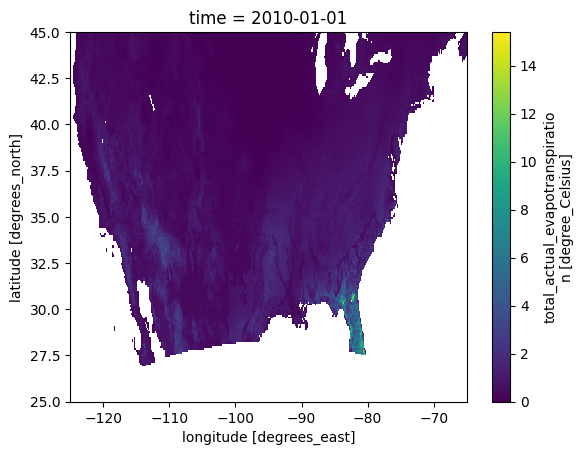

In [28]:
rt = ET_total_actual["total_actual_evapotranspiration"].sel(time = "2010-01-01")[:, :].plot()
# num_elements_equal_to_10 = (rt < 0).sum()
# num_elements_equal_to_10

In [ ]:
Pre = xr.open_dataset(f"{data_path}{list_files['P'][list_files['P']['year'] == 2010]['file'].values[0]}")
pre_day = Pre.to_array()[0, 0, :, :]



cn = xr.open_dataset("D:\mehdi\DailyData\curve_number_1979001.nc")
cn_day = cn.to_array()[0, 0, :, :]
# soil_water_content = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")
# soil_water_content_evaporation = soil_water_content["volumetric_soil_water_layer_1"]
data_type = cn_day.dtype
data_type
# ss = np.vectorize(PrimarySurfaceFlow.scs)(
#     precipitation = pre_day,
#     curve_number = cn["dry"].sel(time = "1979-01-01")[:, :],
#     rsa = True,
#     antecedent_precipitation = soil_water_content_evaporation.sel(time = "1979-01-01")[:, :],
#     is_growing_season = True
# )


In [ ]:
pre_day

In [ ]:
ee = ET_total_actual["total_actual_evapotranspiration"].sel(time = "2010-01-01")
dd = ee.max()
float_value = dd.item()
float_value

In [ ]:
d = TE["total_evaporable_water"].sel(time = "2010-01-01")

df = d.to_dataframe()

min_value = df['total_evaporable_water'].min()
max_value = df['total_evaporable_water'].max()
print(min_value, max_value)

In [ ]:
d = TE["total_evaporable_water"].sel(time = "2010-01-01")
dd = d.min()
float_value = dd.item()
float_value

In [ ]:
# ET_actual.actual_evapotranspiration.sel(time = "2010-01-01")[:,:].plot()
d = Tmin_day.extraterrestrial_radiation.sel(time = "2010-01-01")

df = d.to_dataframe()

min_value = df['extraterrestrial_radiation'].min()
max_value = df['extraterrestrial_radiation'].max()
print(min_value, max_value)
# df.to_csv("D:\mehdi\et_for_2010_01_01.csv", index=False) 

In [ ]:
Ra

In [ ]:
xr.DataArray(
            Tmin.air_temperature,
            coords={
                "time" : Tmin.time.values,
                "lat" : Tmin_day.lat.values,
                "lon" : Tmin_day.lon.values,
            }, 
            dims=['time', 'lat', 'lon']
        )

In [ ]:
Tmin

In [ ]:
with open('D:\\mehdi\\DailyData\\Tmax\\Tmax-30.pkl', 'rb') as f:
    t_max11 = pickle.load(f)

with open('D:\\mehdi\\DailyData\\Tmax\\Tmax-31.pkl', 'rb') as f:
    t_max12 = pickle.load(f)


concatenated_data = xr.concat([t_max11, t_max12], dim='time')
sliced_dataset = concatenated_data.sel(time=slice("2010-01-01", "2010-12-31"))



reshaped_data = result_ET_array.reshape(365,200, 600)

ds_array = sliced_dataset.assign(ET=(['time', 'lat', 'lon'], reshaped_data))

ds_array

In [ ]:
Tmin_day

In [ ]:
# result_array.size
# ET_ca_array = result_array.reshape(365,200,600)
t = Tmin.assign(ra=(['time', 'lat', 'lon'], result_array))
t

In [ ]:
yy = xr.open_dataset("D:\\mehdi\\DailyData\\Data\\Tmax_2010.nc")
yy.sel(time = "2010-01-01")

In [ ]:
def check_between(
    a: float,
    min: float,
    max: float,
    name: str,
):
    if a < min or a > max:
        raise ValueError(f"{name} must be between {min} and {max}!")

In [ ]:
Tmean_day

In [ ]:
for year in list_of_year[:2]:
    t_min_{year} = xr.open_dataset(f"Data\\Tmin_{1979}.nc")
    t_max_{year} = xr.open_dataset(f"Data\\Tmax_{1979}.nc")
    
    for i in range(t_min.sizes["time"]):
        print(i)

In [ ]:
import os
import sys

sys.path.append('D:\\mehdi\\WaterBalance_new\\')

from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *

In [ ]:
time_list = a['time'].values.astype(str).tolist()

In [ ]:
array_t_min = a.air_temperature.to_numpy()
array_t_min

In [ ]:
vectorized_func = np.vectorize(standard_date_to_Julian_day)
result = vectorized_func(array_t_min)
result